##### top

# Simulate potential span and range of reliabilities estimated using attenuation correction across days

This ntb looks at synthetic data following a selection of Cs and estimates the range of possible reliabilities that we could observe by chance if we use attenuation correction on two separate days. The idea is to check the effect of possible outliers that drove this reliability to be more than one in the original dataset.

* [Use simulations of different Cs to get a range/CI for the curves](#Use-simulations-of-different-Cs-to-get-a-range/CI-for-the-curves)

In [1]:
import os, sys
import time
import pickle 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define path and name
csv_clean_data_path = "../Data/cleaned_CSV" 

path_results = "../Data/results"
path_meaning = os.path.join(path_results, "reliability_meaning")

# Importing module for functions
functions_modul =  "./functions"
sys.path.insert(0, functions_modul)

# import all processing and plotting functions
from reliability_functions import bin_samples_rand4, calculate_reliability_between_two_groups, analytical_C_unbiased
from simulation_functions import get_subject_means
from data_processing_functions import process_and_concatenate_all_tasks

def get_true_correlation(r_xy_prime, r_xx_prime, r_yy_prime):
    return r_xy_prime/np.sqrt(r_xx_prime*r_yy_prime)

task_files = [
 'CCMT-cleaned_data.csv',
 'CCMT-cleaned_data_rep.csv',
#  'CFMT-cleaned_data.csv',
#  'CFMT_Aus-cleaned_data.csv',
#  'CFMT_Aus2-cleaned_data.csv',
#  'CFMT_F-cleaned_data.csv',
#  'CFMT_F2-cleaned_data.csv',
#  'FMP-cleaned_data.csv',
#  'FMP-cleaned_data_rep.csv',
#  'GFMT-cleaned_data.csv',
#  'GFMT-cleaned_data_rep.csv',
 'MST-cleaned_data.csv',
 'MST-cleaned_data_rep.csv',
#  'PGNG-cleaned_data.csv',
#  'PGNG-cleaned_data_rep.csv',
 'PIM_MC-cleaned_data.csv',
 'PIM_MC-cleaned_data_rep.csv',
#  'PIM_recog-cleaned_data.csv',
#  'PIM_recog-cleaned_data_rep.csv',
#  'RISE-cleaned_data.csv',
 'SCAP-cleaned_data.csv',
 'SCAP-cleaned_data_rep.csv',
#  'VET_birds-cleaned_data.csv',
#  'VET_leaves-cleaned_data.csv',
#  'VET_planes-cleaned_data.csv',
#  'car_matching-cleaned_data.csv',
#  'car_matching-cleaned_data_rep.csv',
 'emotion_labelling-cleaned_data.csv',
 'emotion_labelling_rep-cleaned_data.csv',
#  'emotion_matching-cleaned_data.csv',
#  'emotion_matching_rep-cleaned_data.csv',
#  'nback-cleaned_data_day1.csv',
#  'nback-cleaned_data_day2.csv'
]
print(len(task_files))


task_names = [
 'CCMT',
#  'CFMT',
#  'FMP',
#  'GFMT',
 'MST',
#  'PGNG',
 'PIM_MC',
#  'PIM_recog',
#  'RISE',
 'SCAP',
#  'VET_birds',
#  'VET_leaves',
#  'VET_planes',
#  'car_matching',
 'emotion_labelling',
#  'emotion_matching',
#  'nback',
]

print(f'Unique tasks: {len(task_names)}')

dataframe_list, dic_num_subjects_per_task, df_wide, df_normed_wide, completed_subjects, all_anything_subjects, VET_shared_subjects = process_and_concatenate_all_tasks(task_names, task_files, csv_clean_data_path)



10
Unique tasks: 5
CCMT
Running total 154 participants (out of 243 in first repetition).
MST
Running total 84 participants (out of 231 in first repetition).
PIM_MC
Running total 152 participants (out of 249 in first repetition).
SCAP
Running total 162 participants (out of 247 in first repetition).
emotion_labelling
Test first set:  emotion_labelling
Series([], Name: userID, dtype: int64)

Test second set
Series([], Name: userID, dtype: int64)
Running all replicate studies with total 166 participants (out of 242 in first repetition) and 45 stimuli.


This should be as before: 10; then this is how many files is left and what they are:
 0 []

-->There are 74 subjects who have all the tasks.

-->There are 182 subjects who have all repetitions of at least one task.

-->There are 218 subjects who have at least one repetition of all tasks.


In [2]:
def get_mean_sd_C_task(task_name, dataframe_list, std_thr=None, measure="correct"):
    # get PIM
    df_task = [x for x in dataframe_list if x.task.str.contains(task_name).all()][0]
    
    # deal with PIM
    if task_name == "PIM_MC":
        df_task = pd.melt(df_task[['userID', 'hobby', 'vice', 'code_name', 'country', 'form']], 
                          id_vars=['userID', 'form'], value_name='correct')
        
        sort_cols = ['userID', 'variable', 'form']
    else:
        sort_cols = ['userID', 'form']

    # do cleaning - drop participants whose difference in score on first and second step is large
    # define threshold for removing outliers
    if std_thr is not None:
        # compute the score difference
        tmp_score_diff = df_task.loc[df_task["form"]=="original", ["userID", measure]].groupby('userID').mean() - df_task.loc[df_task["form"]=="repetition", ["userID", measure]].groupby('userID').mean()
        mu = tmp_score_diff.mean()[0]
        std = tmp_score_diff.std()[0]
        outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
        df_task_cleaned = df_task[~df_task['userID'].isin(outliers)].sort_values(by=sort_cols, kind='stable', ignore_index=True)
        print(f'Droping {len(outliers)} outliers')
    else:
        df_task_cleaned = df_task.copy()
        
    # get mean
    mean = df_task_cleaned[measure].mean()
    var = df_task_cleaned.groupby('userID')[measure].mean().var()
    # check
    n_trials = df_task_cleaned.userID.value_counts().unique()
    assert n_trials.size == 1
    
    # get C
    C = analytical_C_unbiased(mean, var, n_trials[0])
    return mean, df_task_cleaned.groupby('userID')[measure].mean().std(), var, C


In [3]:
# def get_mean_sd_ab_C_task(task_name, dataframe_list, std_thr=None, measure="correct"):
#     # get PIM
#     df_task = [x for x in dataframe_list if x.task.str.contains(task_name).all()][0]
    
#     # deal with PIM
#     if task_name == "PIM_MC":
#         df_task = pd.melt(df_task[['userID', 'hobby', 'vice', 'code_name', 'country', 'form']], 
#                           id_vars=['userID', 'form'], value_name='correct')
        
#         sort_cols = ['userID', 'variable', 'form']
#     else:
#         sort_cols = ['userID', 'form']

#     # do cleaning - drop participants whose difference in score on first and second step is large
#     # define threshold for removing outliers
#     if std_thr is not None:
#         # compute the score difference
#         tmp_score_diff = df_task.loc[df_task["form"]=="original", ["userID", measure]].groupby('userID').mean() - df_task.loc[df_task["form"]=="repetition", ["userID", measure]].groupby('userID').mean()
#         mu = tmp_score_diff.mean()[0]
#         std = tmp_score_diff.std()[0]
#         outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
#         df_task_cleaned = df_task[~df_task['userID'].isin(outliers)].sort_values(by=sort_cols, kind='stable', ignore_index=True)
#         print(f'Droping {len(outliers)} outliers')
#     else:
#         df_task_cleaned = df_task.copy()
        
#     # get mean and fits
#     alpha, beta, mean, corr_var = beta_fit_using_moments(df_task_cleaned[measure])
#     assert mean == df_task_cleaned[measure].mean()
#     # check
#     n_trials = df_task_cleaned.userID.value_counts().unique()
#     assert n_trials.size == 1
    
#     # get C
#     C = analytical_C_unbiased(mean, df_task_cleaned.groupby('userID')[measure].mean().var(), n_trials[0])
#     return mean, df_task_cleaned.groupby('userID')[measure].mean().std(), alpha, beta, C


In [4]:
for task in task_names:
    print(task, get_mean_sd_C_task(task, dataframe_list, std_thr=2))

Droping 6 outliers
CCMT (0.6913006756756757, 0.1335626847542292, 0.017838990758757604, 11.95603370903058)
Droping 4 outliers
MST (0.79716796875, 0.06578496070951786, 0.00432766105555281, 38.61664310200413)
Droping 8 outliers
PIM_MC (0.7721715856481481, 0.1697373675811923, 0.028810773953392783, 5.273864018731908)
Droping 10 outliers
SCAP (0.8681202175716788, 0.08686634656532381, 0.007545762165606944, 15.841554820417002)
Droping 7 outliers
emotion_labelling (0.7166993830622547, 0.09718989873776072, 0.009445876416656184, 26.926180900645505)


## Use simulations of different Cs to get a range/CI for the curves
[top](#top)

Because I need to decide mean and sd to get a C, I will use real data to simulate the distribution and generate it according to this distribution. I will start with 5 Cs: PIM MC, CCMT, SCAP, Emotion labelling, MST  = 5.5, 12.2, 15.4, 26.6, 32

Test it for N=140 as the mean of the Ns in Fig. 4c and for n=40, 50, 60. We want n=40 as L=20 is the shared point for all tasks, we want to test a bit more ns just to know if it behaves well.


* Use simulations to get these ranges, use different Cs, use bunch of them, if they behave the same, then choose one
* these are way too different
* add a significant * to panel C of Fig 4  for tasks where it is significant  

* stats for FMP longitudinal, do simulations

In [5]:
# for how many subjects to compute it, this is a mean of the ones in panel C
N_sim = 140

# define the data
n_trials = 40
mean, std, var, C = get_mean_sd_C_task('PIM_MC', dataframe_list, std_thr=2)

rng_means = np.random.default_rng(0)
means = get_subject_means(C/2, C//2, N_sim, 'beta', rng_means)

rng_data = np.random.default_rng(0)
concat_array_C_PIM = bin_samples_rand4(rng_data, N_sim, n_trials, means, ravel=False)

# print(concat_array.shape)
print(f"Mean in real data: {mean}")
print(f"Mean in simulated data: {concat_array_C_PIM.mean()}")
print(f"Are means close: {np.isclose(means.mean(), concat_array_C_PIM.mean(), atol=10**-3)}")
C_sim = analytical_C_unbiased(concat_array_C_PIM.mean(), np.var(concat_array_C_PIM.mean(axis=1), ddof=1), n_trials)
print(f"C={C}, C sim={C_sim}")
print(f"Are Cs close: {np.isclose(C, C_sim, atol=10**-2)}")
print(f"N={N_sim}")

Droping 8 outliers
Mean in real data: 0.7721715856481481
Mean in simulated data: 0.5678571428571428
Are means close: False
C=5.273864018731908, C sim=5.239500601218565
Are Cs close: False
N=140


In [6]:
# define the data
dic_tasks_results = {}

# set step separately
step = 10

# define how many times to split the data
n_splits = 10
n_repeats = 10**3

# for how many subjects to compute it, this is a mean of the ones in panel C
N_sim = 140

# define the data
task = "PIM_MC"
print(task)
dic_tasks_results[task] = {}
mean, std, var, C = get_mean_sd_C_task(task, dataframe_list, std_thr=2)
dic_tasks_results[task]["original_C"] = C
dic_tasks_results[task]["defined_C"] = C/2 + C//2 # alpha+beta in the beta distribution below
    
# define how many trials we want to check, this is how many trials there are in the concat version, e.g. in GFMT there is 2*40
total_n_trials_list = [40, 80, 120]

# start the timer
start = time.time()

for n_trials in total_n_trials_list:
    print(n_trials)
    # create data
    rng_means = np.random.default_rng(0)
    means = get_subject_means(C/2, C//2, N_sim, 'beta', rng_means)

    rng_data = np.random.default_rng(0)
    concat_array_C = bin_samples_rand4(rng_data, N_sim, n_trials, means, ravel=False)
    
    ## Run the simulations

    # predefine arrays
    array_corr_fxn_orig = np.zeros((n_splits, n_trials//4//step, n_repeats))
    array_corr_fxn_rep = np.zeros((n_splits, n_trials//4//step, n_repeats))
    array_corr_fxn_orig_vs_rep = np.zeros((n_splits, n_trials//2//step, n_repeats))
    r_xy_array = np.zeros((n_splits, n_trials//4//step))

    # simulate the different splits
    for s in range(n_splits):
        # define random splitter
        rng_split = np.random.default_rng(s)

        # split the data into two days
        random_idx = rng_split.choice(range(concat_array_C.shape[1]), n_trials//2, replace=False)
        random_idx2 = np.asarray(list(set(range(concat_array_C.shape[1])) - set(random_idx)))
    #     random_idx, random_idx2 = np.split(np.random.permutation(np.arange(PIM_MC_concat_shape)), 2)

        day1_array = concat_array_C[:, random_idx]
        day2_array = concat_array_C[:, random_idx2]

        ### Run analysis
        ## Short arrays
        array_corr_fxn_orig[s], n_trials_list_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials//2, n_repeats=n_repeats, step=step)
        array_corr_fxn_rep[s], n_trials_list_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials//2, n_repeats=n_repeats, step=step)

        ## Long arrays
        array_corr_fxn_orig_vs_rep[s], n_trials_list_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, n_trials, n_repeats=n_repeats, step=step)

    
        # get the true correlation
        r_xy_array[s] = get_true_correlation(
            np.nanmean(array_corr_fxn_orig_vs_rep[s, :len(n_trials_list_orig)], axis=1),
            np.nanmean(array_corr_fxn_orig[s], axis=1), 
            np.nanmean(array_corr_fxn_rep[s], axis=1)
        )
    
    # save
    dic_tasks_results[task][n_trials] = {
        'data': concat_array_C,
        'array_corr_fxn_orig': array_corr_fxn_orig,
        'n_trials_list_orig': n_trials_list_orig,
        'array_corr_fxn_rep': array_corr_fxn_rep,
        'n_trials_list_rep': n_trials_list_rep,
        'array_corr_fxn_orig_vs_rep': array_corr_fxn_orig_vs_rep,
        'n_trials_list_orig_vs_rep': n_trials_list_orig_vs_rep,
        'r_xy_array': r_xy_array,
    }

print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")


PIM_MC
Droping 8 outliers
40
Process took: 0.24 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.26 s which is 0.00 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process too

In [7]:
# dic_tasks_results[task][80]

In [8]:
# dic_tasks_results[task][80]['r_xy_array']

In [9]:
# make a copy
dic_tasks_results_backup = dic_tasks_results

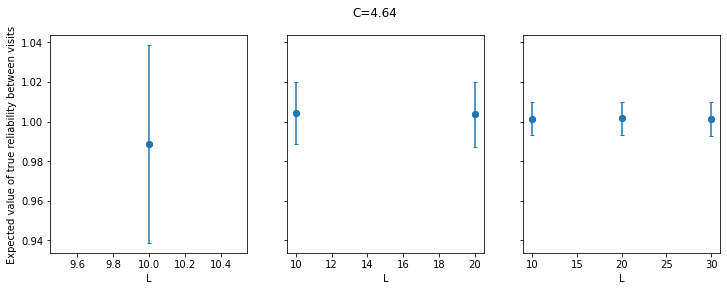

In [10]:
fig, axs = plt.subplots(1,3, figsize=(12,4), sharey=True)

for n_trials, ax in zip(total_n_trials_list, axs.flatten()):
    r_xy_array = dic_tasks_results[task][n_trials]['r_xy_array']
    
    ax.scatter(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0))
    ax.errorbar(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0), 
                yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)

    if n_trials==total_n_trials_list[0]:
        ax.set_ylabel('Expected value of true reliability between visits')
    else:
        ax.set_ylabel('')
    ax.set_xlabel('L')

plt.suptitle(f"C={dic_tasks_results[task]['defined_C']:.2f}")
plt.show()
# axs[1].scatter(n_trials_list_GFMT_orig, r_xy_array.mean(axis=0))
# axs[1].errorbar(n_trials_list_GFMT_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
# axs[1].set_ylabel('Expected value of true reliability between visits')
# axs[1].set_xlabel('L')


### Run it for all Cs without anything from the task
[top](#top)

In [11]:
# define the data
dic_tasks_results = {}

# set step separately
step = 10

# define how many times to split the data
n_splits = 100
n_repeats = 10**3

# for how many subjects to compute it, this is a mean of the ones in panel C
N_sim = 140

# define how many trials we want to check, this is how many trials there are in the concat version, e.g. in GFMT there is 2*40
total_n_trials_list = [40, 80, 120]

# start the timer
start = time.time()

# C_list = [5.5, 12.2, 15.4, 26.6, 32]

for task in task_names:
    # define the data
    print(task)
    dic_tasks_results[task] = {}
    mean, std, var, C = get_mean_sd_C_task(task, dataframe_list, std_thr=2)
    dic_tasks_results[task]["original_C"] = C
    dic_tasks_results[task]["defined_C"] = C/2+C/2 # alpha+beta in the beta distribution below
    
    # start the timer
    start_C = time.time()

    for n_trials in total_n_trials_list:
        print(n_trials)
        # create data
        rng_means = np.random.default_rng(0)
        means = get_subject_means(C/2, C/2, N_sim, 'beta', rng_means)

        rng_data = np.random.default_rng(0)
        concat_array_C = bin_samples_rand4(rng_data, N_sim, n_trials, means, ravel=False)

        ## Run the simulations

        # predefine arrays
        array_corr_fxn_orig = np.zeros((n_splits, n_trials//4//step, n_repeats))
        array_corr_fxn_rep = np.zeros((n_splits, n_trials//4//step, n_repeats))
        array_corr_fxn_orig_vs_rep = np.zeros((n_splits, n_trials//2//step, n_repeats))
        r_xy_array = np.zeros((n_splits, n_trials//4//step))

        # simulate the different splits
        for s in range(n_splits):
            # define random splitter
            rng_split = np.random.default_rng(s)

            # split the data into two days
            random_idx = rng_split.choice(range(concat_array_C.shape[1]), n_trials//2, replace=False)
            random_idx2 = np.asarray(list(set(range(concat_array_C.shape[1])) - set(random_idx)))
        #     random_idx, random_idx2 = np.split(np.random.permutation(np.arange(PIM_MC_concat_shape)), 2)

            day1_array = concat_array_C[:, random_idx]
            day2_array = concat_array_C[:, random_idx2]

            ### Run analysis
            ## Short arrays
            array_corr_fxn_orig[s], n_trials_list_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials//2, n_repeats=n_repeats, step=step)
            array_corr_fxn_rep[s], n_trials_list_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials//2, n_repeats=n_repeats, step=step)

            ## Long arrays
            array_corr_fxn_orig_vs_rep[s], n_trials_list_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, n_trials, n_repeats=n_repeats, step=step)


            # get the true correlation
            r_xy_array[s] = get_true_correlation(
                np.nanmean(array_corr_fxn_orig_vs_rep[s, :len(n_trials_list_orig)], axis=1),
                np.nanmean(array_corr_fxn_orig[s], axis=1), 
                np.nanmean(array_corr_fxn_rep[s], axis=1)
            )

        # save
        dic_tasks_results[task][n_trials] = {
            'data': concat_array_C,
            'array_corr_fxn_orig': array_corr_fxn_orig,
            'n_trials_list_orig': n_trials_list_orig,
            'array_corr_fxn_rep': array_corr_fxn_rep,
            'n_trials_list_rep': n_trials_list_rep,
            'array_corr_fxn_orig_vs_rep': array_corr_fxn_orig_vs_rep,
            'n_trials_list_orig_vs_rep': n_trials_list_orig_vs_rep,
            'r_xy_array': r_xy_array,
            'computed_C': analytical_C_unbiased(concat_array_C.mean(), np.var(concat_array_C.mean(axis=1), ddof=1), n_trials)
        }

    print(f"C took: {time.time() - start:.2f} s which is {(time.time() - start_C) / 60:.2f} min.\n")

print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")


CCMT
Droping 6 outliers
40
Process took: 0.24 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.48 s which is 0.01 min.
Process took:

Process took: 0.24 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.


Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.88 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.


Process took: 0.83 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.49 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.51 s which is 0.03 min.
Process took: 0.75 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.44 s which is 0.02 min.
Process took: 0.75 s which is 0.01 min.
Process took: 0.71 s which is 0.01 min.
Process took: 1.48 s which is 0.02 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 1.48 s which is 0.02 min.
Process took: 0.75 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 1.43 s which is 0.02 min.
Process took: 0.81 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 1.48 s which is 0.02 min.
Process took: 0.78 s which is 0.01 min.
Process took: 0.77 s which is 0.01 min.
Process took: 1.40 s which is 0.02 min.
Process took: 0.72 s which is 0.01 min.


Process took: 0.76 s which is 0.01 min.
Process took: 1.46 s which is 0.02 min.
Process took: 0.75 s which is 0.01 min.
Process took: 0.75 s which is 0.01 min.
Process took: 1.46 s which is 0.02 min.
Process took: 0.72 s which is 0.01 min.
Process took: 0.73 s which is 0.01 min.
Process took: 1.49 s which is 0.02 min.
Process took: 0.76 s which is 0.01 min.
Process took: 0.78 s which is 0.01 min.
Process took: 1.44 s which is 0.02 min.
Process took: 0.75 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.43 s which is 0.02 min.
Process took: 0.75 s which is 0.01 min.
Process took: 0.71 s which is 0.01 min.
Process took: 1.44 s which is 0.02 min.
Process took: 0.75 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.46 s which is 0.02 min.
Process took: 0.72 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.44 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.


Process took: 0.25 s which is 0.00 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.25 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.26 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.25 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.25 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.25 s which is 0.00 min.


Process took: 0.99 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.


Process took: 0.73 s which is 0.01 min.
Process took: 1.43 s which is 0.02 min.
Process took: 0.74 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.44 s which is 0.02 min.
Process took: 0.72 s which is 0.01 min.
Process took: 0.75 s which is 0.01 min.
Process took: 1.46 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.75 s which is 0.01 min.
Process took: 1.43 s which is 0.02 min.
Process took: 0.74 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.44 s which is 0.02 min.
Process took: 0.77 s which is 0.01 min.
Process took: 0.73 s which is 0.01 min.
Process took: 1.47 s which is 0.02 min.
Process took: 0.74 s which is 0.01 min.
Process took: 0.71 s which is 0.01 min.
Process took: 1.42 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.44 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.


Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.25 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.22 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.


Process took: 0.46 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.25 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.25 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.26 s which is 0.00 min.
Process took: 0.25 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.25 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.


Process took: 0.73 s which is 0.01 min.
Process took: 1.41 s which is 0.02 min.
Process took: 0.71 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.
Process took: 1.42 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.44 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.42 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.73 s which is 0.01 min.
Process took: 1.42 s which is 0.02 min.
Process took: 0.74 s which is 0.01 min.
Process took: 0.73 s which is 0.01 min.
Process took: 1.42 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.75 s which is 0.01 min.
Process took: 1.43 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.
Process took: 1.43 s which is 0.02 min.
Process took: 0.75 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.


Process took: 1.42 s which is 0.02 min.
Process took: 0.70 s which is 0.01 min.
Process took: 0.71 s which is 0.01 min.
Process took: 1.39 s which is 0.02 min.
Process took: 0.73 s which is 0.01 min.
Process took: 0.73 s which is 0.01 min.
Process took: 1.37 s which is 0.02 min.
Process took: 0.72 s which is 0.01 min.
Process took: 0.70 s which is 0.01 min.
Process took: 1.53 s which is 0.03 min.
Process took: 0.71 s which is 0.01 min.
Process took: 0.73 s which is 0.01 min.
Process took: 1.43 s which is 0.02 min.
Process took: 0.72 s which is 0.01 min.
Process took: 0.70 s which is 0.01 min.
Process took: 1.42 s which is 0.02 min.
Process took: 0.71 s which is 0.01 min.
Process took: 0.71 s which is 0.01 min.
Process took: 1.41 s which is 0.02 min.
Process took: 0.75 s which is 0.01 min.
Process took: 0.72 s which is 0.01 min.
Process took: 1.42 s which is 0.02 min.
Process took: 0.74 s which is 0.01 min.
Process took: 0.73 s which is 0.01 min.
Process took: 1.47 s which is 0.02 min.


Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.22 s which is 0.00 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.22 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.22 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.24 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.25 s which is 0.00 min.
Process took: 0.47 s which is 0.01 min.


Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.45 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.88 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.88 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.86 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
120
Process took: 0.68 s which is 0.01 min.
Process took: 0.69 s which is 0.01 m

Process took: 1.39 s which is 0.02 min.
Process took: 0.69 s which is 0.01 min.
Process took: 0.70 s which is 0.01 min.
Process took: 1.41 s which is 0.02 min.
Process took: 0.68 s which is 0.01 min.
Process took: 0.70 s which is 0.01 min.
Process took: 1.34 s which is 0.02 min.
Process took: 0.69 s which is 0.01 min.
Process took: 0.68 s which is 0.01 min.
Process took: 1.35 s which is 0.02 min.
Process took: 0.69 s which is 0.01 min.
Process took: 0.67 s which is 0.01 min.
Process took: 1.33 s which is 0.02 min.
Process took: 0.69 s which is 0.01 min.
Process took: 0.70 s which is 0.01 min.
Process took: 1.35 s which is 0.02 min.
Process took: 0.71 s which is 0.01 min.
Process took: 0.69 s which is 0.01 min.
Process took: 1.35 s which is 0.02 min.
Process took: 0.69 s which is 0.01 min.
Process took: 0.69 s which is 0.01 min.
Process took: 1.34 s which is 0.02 min.
Process took: 0.71 s which is 0.01 min.
Process took: 0.69 s which is 0.01 min.
Process took: 1.35 s which is 0.02 min.


Process took: 0.23 s which is 0.00 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.25 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.44 s which is 0.01 min.
Process took: 0.22 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.22 s which is 0.00 min.
Process took: 0.22 s which is 0.00 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.22 s which is 0.00 min.
Process took: 0.21 s which is 0.00 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.22 s which is 0.00 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.21 s which is 0.00 min.
Process took: 0.22 s which is 0.00 min.


Process took: 0.42 s which is 0.01 min.
Process took: 0.22 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.43 s which is 0.01 min.
Process took: 0.22 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.42 s which is 0.01 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.23 s which is 0.00 min.
Process took: 0.42 s which is 0.01 min.
80
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.87 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.88 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.88 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.88 s which is 0.01 mi

Process took: 0.50 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.53 s which is 0.01 min.
Process took: 1.02 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.58 s which is 0.01 min.
Process took: 1.11 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.11 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.11 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.


Process took: 0.83 s which is 0.01 min.
Process took: 1.70 s which is 0.03 min.
Process took: 0.88 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 1.75 s which is 0.03 min.
Process took: 0.88 s which is 0.01 min.
Process took: 0.79 s which is 0.01 min.
Process took: 1.73 s which is 0.03 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.37 s which is 0.02 min.
Process took: 0.71 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 1.56 s which is 0.03 min.
Process took: 0.70 s which is 0.01 min.
Process took: 0.76 s which is 0.01 min.
Process took: 1.46 s which is 0.02 min.
Process took: 0.71 s which is 0.01 min.
Process took: 0.73 s which is 0.01 min.
Process took: 1.40 s which is 0.02 min.
Process took: 0.74 s which is 0.01 min.
Process took: 0.74 s which is 0.01 min.
Process took: 1.35 s which is 0.02 min.
Process took: 0.69 s which is 0.01 min.
Process took: 0.70 s which is 0.01 min.


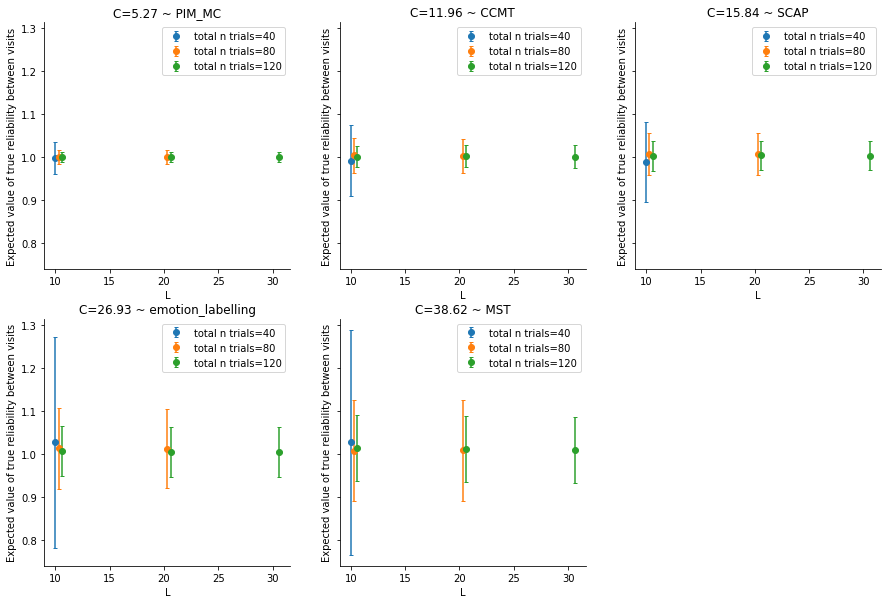

In [12]:
# fig, axs = plt.subplots(len(dic_tasks_results.keys()),1, figsize=(4,18), sharey=True)
fig, axs = plt.subplots(2,3, figsize=(15,10), sharey=True)

assert set(dic_tasks_results.keys()) == set(['PIM_MC', 'CCMT', 'SCAP', 'emotion_labelling', 'MST'])

for (j, task),ax in zip(enumerate(['PIM_MC', 'CCMT', 'SCAP', 'emotion_labelling', 'MST']), axs.flatten()):
    for i, n_trials in enumerate(total_n_trials_list):
        r_xy_array = dic_tasks_results[task][n_trials]['r_xy_array']

    #     ax.scatter(dic_tasks_results[task][n_trials]['n_trials_list_orig']+0.2, r_xy_array.mean(axis=0), label=f'n trials={n_trials}')
        ax.errorbar(dic_tasks_results[task][n_trials]['n_trials_list_orig']+i*0.3, r_xy_array.mean(axis=0), 
                yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2, label=f'total n trials={n_trials}')

    ax.set_ylabel('Expected value of true reliability between visits')
    ax.set_xlabel('L')
    ax.set_title(f"C={dic_tasks_results[task]['defined_C']:.2f} ~ {task}")
    ax.legend()
    
sns.despine()
axs[-1,-1].remove()
# plt.suptitle(f"C={dic_tasks_results[task]['defined_C']:.2f}")
plt.show()

In [13]:
# save
with open(os.path.join(path_results, f'simulated_reliability_range_nsim_{n_splits}.pkl'), 'wb') as f:
    pickle.dump(dic_tasks_results, f)
        


In [17]:
# define the data
dic_tasks_results = {}

# set step separately
step = 10

# define how many times to split the data
n_splits = 1000
n_repeats = 10**3

# for how many subjects to compute it, this is a mean of the ones in panel C
N_sim = 140

# define how many trials we want to check, this is how many trials there are in the concat version, e.g. in GFMT there is 2*40
total_n_trials_list = [80]

# start the timer
start = time.time()

# C_list = [5.5, 12.2, 15.4, 26.6, 32]

for task in task_names:
    # define the data
    print(task)
    dic_tasks_results[task] = {}
    mean, std, var, C = get_mean_sd_C_task(task, dataframe_list, std_thr=2)
    dic_tasks_results[task]["original_C"] = C
    dic_tasks_results[task]["defined_C"] = C/2+C/2 # alpha+beta in the beta distribution below
    
    # start the timer
    start_C = time.time()

    for n_trials in total_n_trials_list:
        print(n_trials)
        # create data
        rng_means = np.random.default_rng(0)
        means = get_subject_means(C/2, C/2, N_sim, 'beta', rng_means)

        rng_data = np.random.default_rng(0)
        concat_array_C = bin_samples_rand4(rng_data, N_sim, n_trials, means, ravel=False)

        ## Run the simulations

        # predefine arrays
        array_corr_fxn_orig = np.zeros((n_splits, n_trials//4//step, n_repeats))
        array_corr_fxn_rep = np.zeros((n_splits, n_trials//4//step, n_repeats))
        array_corr_fxn_orig_vs_rep = np.zeros((n_splits, n_trials//2//step, n_repeats))
        r_xy_array = np.zeros((n_splits, n_trials//4//step))

        # simulate the different splits
        for s in range(n_splits):
            # define random splitter
            rng_split = np.random.default_rng(s)

            # split the data into two days
            random_idx = rng_split.choice(range(concat_array_C.shape[1]), n_trials//2, replace=False)
            random_idx2 = np.asarray(list(set(range(concat_array_C.shape[1])) - set(random_idx)))
        #     random_idx, random_idx2 = np.split(np.random.permutation(np.arange(PIM_MC_concat_shape)), 2)

            day1_array = concat_array_C[:, random_idx]
            day2_array = concat_array_C[:, random_idx2]

            ### Run analysis
            ## Short arrays
            array_corr_fxn_orig[s], n_trials_list_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials//2, n_repeats=n_repeats, step=step)
            array_corr_fxn_rep[s], n_trials_list_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials//2, n_repeats=n_repeats, step=step)

            ## Long arrays
            array_corr_fxn_orig_vs_rep[s], n_trials_list_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, n_trials, n_repeats=n_repeats, step=step)


            # get the true correlation
            r_xy_array[s] = get_true_correlation(
                np.nanmean(array_corr_fxn_orig_vs_rep[s, :len(n_trials_list_orig)], axis=1),
                np.nanmean(array_corr_fxn_orig[s], axis=1), 
                np.nanmean(array_corr_fxn_rep[s], axis=1)
            )

        # save
        dic_tasks_results[task][n_trials] = {
            'data': concat_array_C,
            'array_corr_fxn_orig': array_corr_fxn_orig,
            'n_trials_list_orig': n_trials_list_orig,
            'array_corr_fxn_rep': array_corr_fxn_rep,
            'n_trials_list_rep': n_trials_list_rep,
            'array_corr_fxn_orig_vs_rep': array_corr_fxn_orig_vs_rep,
            'n_trials_list_orig_vs_rep': n_trials_list_orig_vs_rep,
            'r_xy_array': r_xy_array,
            'computed_C': analytical_C_unbiased(concat_array_C.mean(), np.var(concat_array_C.mean(axis=1), ddof=1), n_trials)
        }

    print(f"C took: {time.time() - start:.2f} s which is {(time.time() - start_C) / 60:.2f} min.\n")

print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")


CCMT
Droping 6 outliers
80
Process took: 0.47 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 1.02 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took:

Process took: 0.48 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.


Process took: 1.09 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 1.07 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 1.07 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.


Process took: 0.56 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.10 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.13 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.11 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.04 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.06 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 1.08 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.53 s which is 0.01 min.
Process took: 1.17 s which is 0.02 min.
Process took: 0.64 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.07 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.


Process took: 0.58 s which is 0.01 min.
Process took: 1.09 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.03 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.09 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.06 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.09 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.07 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.07 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.


Process took: 1.02 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 1.03 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 1.11 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.06 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.11 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.53 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.


Process took: 0.49 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.53 s which is 0.01 min.
Process took: 1.03 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.


Process took: 0.53 s which is 0.01 min.
Process took: 1.10 s which is 0.02 min.
Process took: 0.61 s which is 0.01 min.
Process took: 0.63 s which is 0.01 min.
Process took: 1.19 s which is 0.02 min.
Process took: 0.71 s which is 0.01 min.
Process took: 0.64 s which is 0.01 min.
Process took: 1.29 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.08 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.58 s which is 0.01 min.
Process took: 1.02 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.59 s which is 0.01 min.
Process took: 1.07 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.53 s which is 0.01 min.
Process took: 1.12 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.10 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.


Process took: 1.07 s which is 0.02 min.
Process took: 0.68 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.05 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.53 s which is 0.01 min.
Process took: 1.10 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.07 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.12 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.07 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.11 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.10 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.09 s which is 0.02 min.


Process took: 0.55 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.09 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.06 s which is 0.02 min.
Process took: 0.59 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.04 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.12 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.03 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.15 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 1.05 s which is 0.02 min.
Process took: 0.60 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.05 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.


Process took: 0.57 s which is 0.01 min.
Process took: 1.07 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 1.06 s which is 0.02 min.
Process took: 0.58 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.12 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.09 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 1.06 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.12 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.07 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 1.06 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.


Process took: 0.98 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 1.02 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.


Process took: 0.53 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.


Process took: 0.49 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.


Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.


Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 1.04 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.


Process took: 0.47 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.


Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 1.03 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.


Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 1.04 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.


Process took: 0.98 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.80 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.


Process took: 0.49 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.90 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.


Process took: 0.98 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 1.03 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 1.04 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 1.05 s which is 0.02 min.


Process took: 0.55 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 1.17 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 1.11 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.60 s which is 0.01 min.
Process took: 1.06 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.60 s which is 0.01 min.
Process took: 1.09 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.03 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.08 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.10 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.58 s which is 0.01 min.
Process took: 1.09 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.


Process took: 0.47 s which is 0.01 min.
Process took: 1.03 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.02 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.


Process took: 1.05 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.04 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 1.04 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 1.09 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.06 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.53 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 1.02 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.04 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.53 s which is 0.01 min.
Process took: 1.04 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.56 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 1.08 s which is 0.02 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.07 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 1.02 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.94 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.


Process took: 0.50 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.46 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.91 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.


Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.55 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.53 s which is 0.01 min.


Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.44 s which is 0.01 min.


Process took: 0.94 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.


Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.


Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.90 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.


Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.


Process took: 1.03 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.02 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.53 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.08 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.53 s which is 0.01 min.
Process took: 1.08 s which is 0.02 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 1.27 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.57 s which is 0.01 min.
Process took: 1.05 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.


Process took: 0.95 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.


Process took: 0.46 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.90 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.


Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.


Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.83 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.


Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.


Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.57 s which is 0.01 min.
Process took: 0.56 s which is 0.01 min.
Process took: 1.09 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 1.03 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.


Process took: 0.47 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.


Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.54 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.


Process took: 0.50 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.


Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.


Process took: 0.50 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.


Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.


Process took: 0.96 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.89 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.


Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.90 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.


Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.


Process took: 0.47 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.


Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.52 s which is 0.01 min.


Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.


Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.


Process took: 0.50 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.


Process took: 0.97 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.95 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.97 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.98 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.94 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.


Process took: 0.48 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.99 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 1.01 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.49 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.52 s which is 0.01 min.
Process took: 0.54 s which is 0.01 min.
Process took: 1.04 s which is 0.02 min.
Process took: 0.51 s which is 0.01 min.
Process took: 0.51 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.50 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.49 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.96 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.


Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 1.00 s which is 0.02 min.
Process took: 0.45 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.


Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.92 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.93 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.47 s which is 0.01 min.
Process took: 0.48 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.46 s which is 0.01 min.
Process took: 0.91 s which is 0.02 min.


In [18]:
# save
with open(os.path.join(path_results, f'simulated_reliability_range_nsim_{n_splits}.pkl'), 'wb') as f:
    pickle.dump(dic_tasks_results, f)

In [14]:
# # for how many subjects to compute it, this is a mean of the ones in panel C
# N_sim = 140

# # define the data
# n_trials = 40
# mean, std, var, C = get_mean_sd_C_task('PIM_MC', dataframe_list, std_thr=2)

# rng_means = np.random.default_rng(46)
# means = get_subject_means(mean, std, N_sim, 'beta', rng_means)

# rng_data = np.random.default_rng(0)
# concat_array_C_PIM = bin_samples_rand4(rng_data, N_sim, n_trials, means, ravel=False)

# # print(concat_array.shape)
# print(f"Mean in real data: {mean}")
# print(f"Mean in simulated data: {concat_array_C_PIM.mean()}")
# print(f"Are means close: {np.isclose(means.mean(), concat_array_C_PIM.mean(), atol=10**-3)}")
# C_sim = analytical_C_unbiased(concat_array_C_PIM.mean(), np.var(concat_array_C_PIM.mean(axis=1), ddof=1), n_trials)
# print(f"C={C}, C sim={C_sim}")
# print(f"Are Cs close: {np.isclose(C, C_sim, atol=10**-3)}")
# print(f"N={N_sim}")

In [15]:
# for i in range(50):
#     rng_means = np.random.default_rng(i)
#     means = get_subject_means(mean, std, N_sim, 'beta', rng_means)
#     if np.isclose(std, means.std(), atol=10**-3):
#         print(f'{i} perfect')
#     elif np.isclose(std, means.std(), atol=5*10**-2):
#         print(f'{i} good')

### Get to know the SD
[top](#top)

The range here is way too different and variable to be effectively used. From another file

```
Emotion labelling
1 SD: 0.96 - 1.07
2 SD: 0.90 - 1.13
3 SD: 0.85 - 1.18
5-95 percentile: 0.92 - 1.09
1-99 percentile: 0.90 - 1.12
Emotion matching
1 SD: 0.91 - 1.09
2 SD: 0.82 - 1.18
3 SD: 0.73 - 1.27
5-95 percentile: 0.86 - 1.13
1-99 percentile: 0.85 - 1.17
GMFT
1 SD: 0.92 - 1.04
2 SD: 0.86 - 1.10
3 SD: 0.80 - 1.16
5-95 percentile: 0.87 - 1.07
1-99 percentile: 0.84 - 1.08
PIM MC
1 SD: 1.00 - 1.01
2 SD: 0.99 - 1.02
3 SD: 0.98 - 1.02
5-95 percentile: 0.99 - 1.01
1-99 percentile: 0.99 - 1.02
Car matching
1 SD: 0.96 - 1.05
2 SD: 0.92 - 1.09
3 SD: 0.88 - 1.14
5-95 percentile: 0.95 - 1.08
1-99 percentile: 0.91 - 1.09
```

In [16]:
%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu -iv

Author: Jan Kadlec

Last updated: Tue Dec 19 2023

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 23.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

sys       : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
pandas    : 1.2.4
numpy     : 1.19.1
matplotlib: 3.6.2
seaborn   : 0.11.1



[top](#top)